In [101]:
import pypsa
import pandas as pd
import pypsa
import numpy as np
import os
import matplotlib.pyplot as plt

run_name = "tango_sweep"


In [64]:
data = pd.read_csv(csvdir+'supply'+'.csv',skiprows=lambda x: x in [0,1,2,4])



noscaling  \
scale                     Unnamed: 1 Unnamed: 2                                             
AC                        generators offwind-ac                              31054.963365   
                                     offwind-dc                              58708.288903   
                                     onwind                                 810231.172120   
                                     ror                                     42350.018595   
                                     solar                                  927373.162785   
...                                                                                   ...   
urban central heat        loads      low-temperature heat for industry       -6747.568795   
                                     urban central heat                    -561517.935981   
urban central water tanks links      urban central water tanks charger1     308633.903334   
                                     urban central water tanks discharger0 -336466.388464   
                          stores     urban central water tanks              326002.739022   

                                                                              Tango_1of10  \
scale                     Unnamed: 1 Unnamed: 2                                             
AC                        generators offwind-ac                              31017.734917   
                                     offwind-dc                              54619.874667   
                                     onwind                                 792233.914790   
                                     ror                                     42349.862919   
                                     solar                                  823818.838682   
...                                                                                   ...   
urban central heat        loads      low-temperature heat for industry       -6511.549935   
                                     urban central heat                    -524788.274015   
urban central water tanks links      urban central water tanks charger1     255252.040476   
                                     urban central water tanks discharger0 -253523.611684   
                          stores     urban central water tanks              240439.192957   

                                                                              Tango_2of10  \
scale                     Unnamed: 1 Unnamed: 2                                             
AC                        generators offwind-ac                              29225.274301   
                                     offwind-dc                              54640.533885   
                                     onwind                                 768742.844870   
                                     ror                                     42350.046801   
                                     solar                                  726572.411090   
...                                                                                   ...   
urban central heat        loads      low-temperature heat for industry       -6275.531075   
                                     urban central heat                    -488058.612050   
urban central water tanks links      urban central water tanks charger1     205201.249689   
                                     urban central water tanks discharger0 -202812.212718   
                          stores     urban central water tanks              192155.795138   

                                                                              Tango_3of10  \
scale                     Unnamed: 1 Unnamed: 2                                             
AC                        generators offwind-ac                              24561.835562   
                                     offwind-dc                              48660.177327   
                                     onwind                                 72

In [374]:
# First, just mess around with csvs

def load_data(file):
    csvdir = 'results/'+run_name+'/csvs/'
    data = pd.read_csv(csvdir+file+'.csv',skiprows=lambda x: x in [0,1,2,4])
    data.set_index(list(data.columns[(np.arange(1+sum(["Unnamed" in c for c in list(data.columns)])))]),inplace=True)
    return data

def normalize_csv(file):
    csvdir = 'results/'+run_name+'/csvs/'
    outdir = "postanalysis/"

    data = pd.read_csv(csvdir+file+'.csv',skiprows=lambda x: x in [0,1,2,4])
    data.set_index(list(data.columns[(np.arange(1+sum(["Unnamed" in c for c in list(data.columns)])))]),inplace=True)
    datanorm = data.divide(data['noscaling'],axis=0)
    if not os.path.exists(os.getcwd()+'/'+csvdir+outdir):
        os.mkdir(os.getcwd()+'/'+csvdir+outdir)
    datanorm.to_csv(csvdir+outdir+file+'_normalized.csv',float_format="%.4f")
    
def aggregate_heat(df,heat_sources):
    #df 
    #heat_sources = ['air heat pump','resistive heater','ground heat pump']
    for s in heat_sources:
        inds = [i for i in df.index if s in i]
        df = pd.concat([df,pd.DataFrame({s : df.loc[inds].sum() }).T],axis=0)
        df = df.drop(inds)
    return df

In [351]:
# Save files with the following csvs, normalized to noscaling scenario

normalize_csv("supply")
normalize_csv("capacities")
normalize_csv("energy")
normalize_csv("costs")


In [82]:
# Aggregate and print total costs

c=load_data("costs")
totc=pd.DataFrame(c.sum())
totc["ratio"] = totc.divide(totc.loc["noscaling"][0],axis=0)
totc.columns = ['total','ratio']
totc.to_csv(csvdir+outdir+"total_costs.csv")
totc

,total,ratio
noscaling,6.592962e+11,1.000000
Tango_1of10,6.193216e+11,0.939368
Tango_2of10,5.805828e+11,0.880610
Tango_3of10,5.431158e+11,0.823781
Tango_4of10,5.064962e+11,0.768238
Tango_5of10,4.703414e+11,0.713399
Tango_6of10,4.350864e+11,0.659925
Tango_7of10,4.019627e+11,0.609684
Tango_8of10,3.706806e+11,0.562237
Tango_9of10,3.406535e+11,0.516693


In [350]:
# display primary energy use
supplygen = load_data("supply_energy").xs('generators', level=1, drop_level=True)
supplygen = supplygen.droplevel("scale")

supplystore = load_data("supply_energy").xs('stores', level=1, drop_level=True)
supplystore = supplystore.droplevel("scale")
supplystore.index = supplystore.index+" from store"
#drop non energy stores
supplystore = supplystore.loc[[i for i in supplystore.index if not ("co2" in i or "water tank" in i)]]
# keep only non cyclical stores
supplystore = supplystore.loc[[i for i in supplystore.index if abs(supplystore.sum(axis=1)[i])>1]]

supply = pd.concat([supplygen,supplystore],axis=0)

# aggregate solar thermal
st_inds = [i for i in supply.index if "solar thermal" in i]
supply = pd.concat([supply,pd.DataFrame({"solar thermal" : supply.loc[st_inds].sum() }).T],axis=0)
supply = supply.drop(st_inds)
supply.to_csv(csvdir+outdir+"primary_energy.csv") 
supplynorm = supply.divide(supply["noscaling"],axis=0)

supplynorm

,noscaling,Tango_1of10,Tango_2of10,Tango_3of10,Tango_4of10,Tango_5of10,Tango_6of10,Tango_7of10,Tango_8of10,Tango_9of10,Tango_10of10
offwind-ac,1.0,0.998882,0.939283,7.879707e-01,0.280075,0.279855,2.799060e-01,2.797471e-01,2.795626e-01,2.791846e-01,2.792856e-01
offwind-dc,1.0,0.932732,0.933220,8.388067e-01,0.817502,0.816070,3.557724e-01,2.202790e-01,2.199029e-01,2.192070e-01,2.196591e-01
onwind,1.0,0.981106,0.954771,8.919401e-01,0.827791,0.765734,7.306622e-01,6.998298e-01,6.089594e-01,5.375783e-01,4.707833e-01
ror,1.0,1.000262,1.000391,1.000411e+00,1.000374,1.000061,1.000366e+00,1.000302e+00,1.000319e+00,1.000265e+00,1.000232e+00
solar,1.0,0.910932,0.823954,7.757163e-01,0.750989,0.717514,6.789063e-01,6.234904e-01,5.816882e-01,5.176559e-01,4.558735e-01
gas,1.0,0.954581,0.874673,9.283311e-01,1.033049,1.123012,1.229898e+00,1.331991e+00,1.438052e+00,1.271005e+00,1.104943e+00
solar rooftop,1.0,1.000019,1.000026,9.995836e-01,0.999353,0.994300,9.915418e-01,8.932554e-01,8.889274e-01,8.817559e-01,8.477379e-01
oil,1.0,200621.599185,466887.790236,4.789327e+05,393794.821038,336740.247809,2.474777e+05,1.673361e+05,7.964102e+04,5.117598e+05,9.420040e+05
biogas from store,1.0,1.000000,1.000000,1.000000e+00,0.642106,0.106278,7.776502e-08,2.991348e-08,1.078193e-08,1.199750e-08,2.105005e-08
solid biomass from store,1.0,1.000000,1.000000,1.000000e+00,1.000000,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,9.369843e-01,8.497974e-01


# TFEC

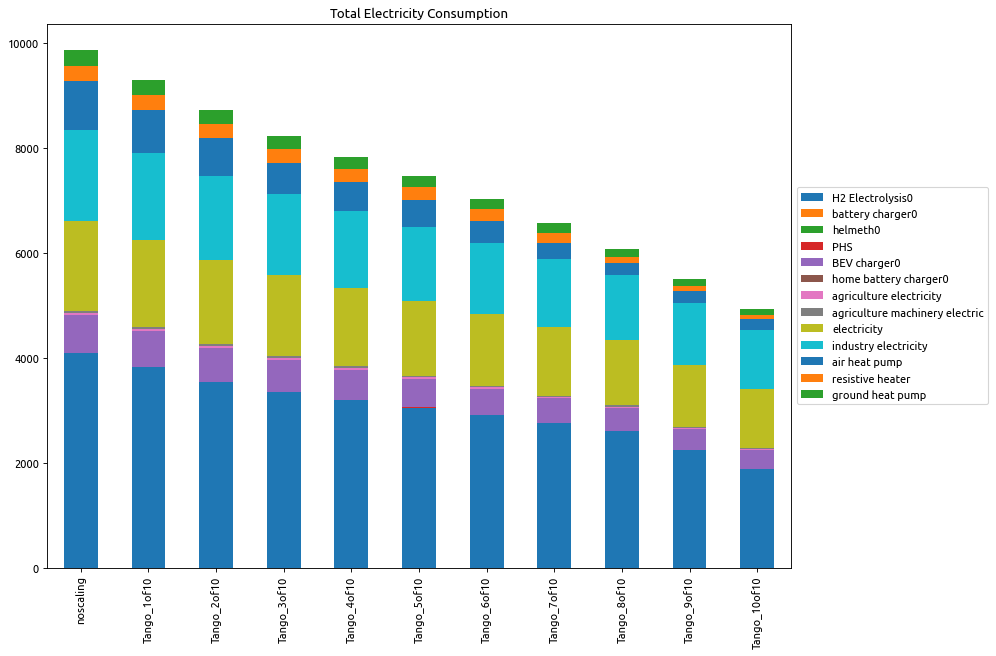

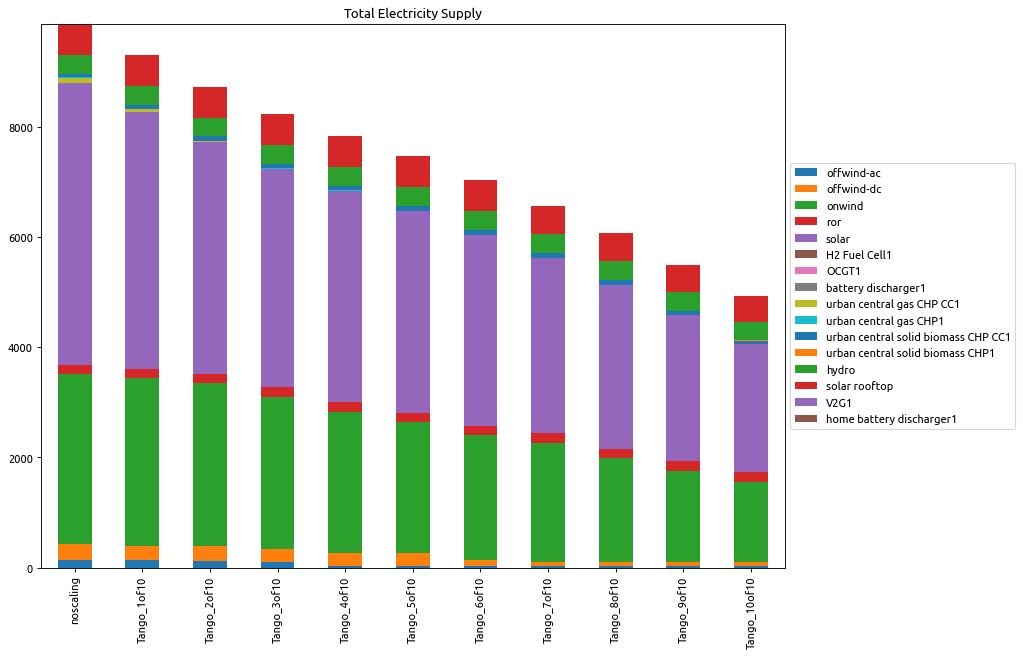

In [391]:
## Electricity Supply and Demand

elec_all = load_data("supply_energy").loc[["AC","low voltage"]]

elec_d = elec_all.loc[[i for i in elec_all.index if elec_all.loc[i]['noscaling']<0]]*-1
elec_d = elec_d.droplevel(["scale","Unnamed: 1"])

elec_s = elec_all.loc[[i for i in elec_all.index if elec_all.loc[i]['noscaling']>0]]
elec_s = elec_s.droplevel(["scale","Unnamed: 1"])


heat_sources = ['air heat pump','resistive heater','ground heat pump']
elec_d = aggregate_heat(elec_d,heat_sources)
elec_d.drop(["electricity distribution grid0","AC1","DC1"],inplace=True) # false variables
elec_d = elec_d/1e6 # convert to TWh

elec_s = elec_s/1e6 # convert to TWh
elec_s.drop(["electricity distribution grid1","AC0","DC0"],inplace=True) # false variable


f = plt.figure(figsize=(12, 9), dpi=80)
plt.title('Total Electricity Consumption', color='black')
elec_d.T.plot(kind='bar', stacked=True, ax=f.gca())
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()
#ax = elec_d.T.plot.bar(stacked=True)

f2 = plt.figure(figsize=(12, 9), dpi=80)
plt.title('Total Electricity Supply', color='black')
elec_s.T.plot(kind='bar', stacked=True, ax=f2.gca())
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()


In [415]:

n = pypsa.Network("results/co2seq_sweep/postnetworks/elec_sc_Tango_s_37_lvopt__Co2L0p01-193H-T-H-B-I-A-seq2e8_2050.nc")
for c in n.iterate_components(n.branch_components|n.controllable_one_port_components^{"Load"}):
    if c.name == "Store":
        stores = c
stores.df.loc["co2 stored"]
#plt.plot(stores.pnl.p["co2 stored"])
#stores.pnl.p["co2 stored"].sum()*193/1e6
n.links.loc[[i for i in n.links.index if "co2" in n.links.loc[i]["bus2"]]]


INFO:pypsa.io:Imported network elec_sc_Tango_s_37_lvopt__Co2L0p01-193H-T-H-B-I-A-seq2e8_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


,bus0,bus1,carrier,geometry,length,p_nom,tags,under_construction,underground,p_min_pu,...,p_nom_opt,charger_ratio,type,build_year,p_nom_max,p_set,p_max_pu,terrain_factor,ramp_limit_up,ramp_limit_down
Link,,,,,,,,,,,,,,,,,,,,,
AL1 0 OCGT,EU gas,AL1 0,OCGT,,0.0,0.0,,NaN,NaN,0.0,...,0.002750,NaN,,0,inf,0.0,1.0,1.0,NaN,NaN
AT1 0 OCGT,EU gas,AT1 0,OCGT,,0.0,0.0,,NaN,NaN,0.0,...,0.002696,NaN,,0,inf,0.0,1.0,1.0,NaN,NaN
BA1 0 OCGT,EU gas,BA1 0,OCGT,,0.0,0.0,,NaN,NaN,0.0,...,0.002522,NaN,,0,inf,0.0,1.0,1.0,NaN,NaN
BE1 0 OCGT,EU gas,BE1 0,OCGT,,0.0,0.0,,NaN,NaN,0.0,...,0.001760,NaN,,0,inf,0.0,1.0,1.0,NaN,NaN
BG1 0 OCGT,EU gas,BG1 0,OCGT,,0.0,0.0,,NaN,NaN,0.0,...,0.002281,NaN,,0,inf,0.0,1.0,1.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RS1 0 Fischer-Tropsch,RS1 0 H2,EU oil,Fischer-Tropsch,,0.0,0.0,,NaN,NaN,0.0,...,0.007816,NaN,,0,inf,0.0,1.0,1.0,NaN,NaN
SE2 0 Fischer-Tropsch,SE2 0 H2,EU oil,Fischer-Tropsch,,0.0,0.0,,NaN,NaN,0.0,...,0.003877,NaN,,0,inf,0.0,1.0,1.0,NaN,NaN
SI1 0 Fischer-Tropsch,SI1 0 H2,EU oil,Fischer-Tropsch,,0.0,0.0,,NaN,NaN,0.0,...,0.003137,NaN,,0,inf,0.0,1.0,1.0,NaN,NaN


In [447]:

#n.loads_t.p_set[[c for c in n.loads_t.p_set.columns if ("GB" in c or "IE" in c) and c.endswith('0')]].sum()

#n.loads_t.p_set.loc[[i for i in n.loads_t.p_set.index if "GB" in i or "IE" in i]]

gb5_lines = [i for i in n.lines.index if "GB5" in n.lines.loc[i]["bus0"] or "GB5" in n.lines.loc[i]["bus1"]]
n.lines.loc[gb5_index]

gb5_links = [i for i in n.links.index if "GB5 0" == n.links.loc[i]["bus0"] or "GB5 0" == n.links.loc[i]["bus1"]]
gb5_links = gb5_links[0:2]
n.links.loc[gb5_links]
#n.lines_t.p0

n.lines_t.p0[gb5_lines].sum()/1e3
n.links_t.p0[gb5_links].sum()/1e3

Link
5581   -80.329840
5580   -11.433049
dtype: float64